## Dependency

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import torchvision
from torchvision import transforms
from torchvision import datasets, models, transforms

import PIL
from PIL import Image

import math
import random
import seaborn as sn
import pandas as pd
import numpy as np
from pathlib import Path
from skimage import io
import pickle
import matplotlib.pyplot as plt
import time
import os
import copy
from tqdm import tqdm_notebook

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

!pip install addict
import argparse, yaml
from addict import Dict

import kagglehub


print("PyTorch Version: ", torch.__version__)
print("Torchvision Version: ", torchvision.__version__)
print("Pillow Version: ", PIL.__version__)

train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

PyTorch Version:  2.6.0+cu124
Torchvision Version:  0.21.0+cu124
Pillow Version:  11.2.1
CUDA is available!  Training on GPU ...


In [2]:
#config 불러오기
def get_cfg():
    parser = argparse.ArgumentParser()
    parser.add_argument("--config", type=str, default="config.yaml")
    args, _ = parser.parse_known_args()

    # args.config 에 지정된 YAML 파일 읽어서 Dict 형태로 반환
    with open(args.config) as f:
        cfg = Dict(yaml.safe_load(f))
    return cfg

cfg = get_cfg()

In [3]:
# Download latest version
path = kagglehub.dataset_download("alexattia/the-simpsons-characters-dataset")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/the-simpsons-characters-dataset


In [4]:
train_dir = Path('/kaggle/input/the-simpsons-characters-dataset/simpsons_dataset')
test_dir = Path('/kaggle/input/the-simpsons-characters-dataset/kaggle_simpson_testset/kaggle_simpson_testset')

In [5]:
#데이터 전처리
class SimpsonTrainValPath():

  def __init__(self, train_dir, test_dir):

    self.train_dir = train_dir
    self.test_dir = test_dir
    self.train_val_files_path = sorted(list(self.train_dir.rglob('*.jpg')))
    self.test_path = sorted(list(self.test_dir.rglob('*.jpg')))
    self.train_val_labels = [path.parent.name for path in self.train_val_files_path]

  def get_path(self):

    train_files_path, val_files_path = train_test_split(self.train_val_files_path, test_size = 0.3, random_state=cfg.data.random_state ,stratify=self.train_val_labels)

    files_path = {'train': train_files_path, 'val': val_files_path}

    return files_path, self.test_path

  def get_n_classes(self):
    return len(np.unique(self.train_val_labels))

In [6]:
SimpsonTrainValPath = SimpsonTrainValPath(train_dir, test_dir)
train_path, test_path = SimpsonTrainValPath.get_path()

In [7]:
def train_model(model, dataloaders, criterion, optimizer, save_best_weights_path, save_last_weights_path, best_acc, num_epochs=cfg.training.epochs, is_inception=False):
    since = time.time()

    val_acc_history = []
    val_loss_history = []
    train_acc_history = []
    train_loss_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # 모드 설정
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in tqdm_notebook(dataloaders[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                # forward
                # 훈련 모드에서 기록 저장
                with torch.set_grad_enabled(phase == 'train'):
                    # loss 계산
                    # inception 모델인 경우
                    if is_inception and phase == 'train':
                        outputs, aux_outputs = model(inputs)
                        loss1 = criterion(outputs, labels)
                        loss2 = criterion(aux_outputs, labels)
                        loss = loss1 + 0.4*loss2
                    else:
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # backward + optimizer train mode
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                #
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            # loss
            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # best 모델 저장
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            # acc 저장
            if phase == 'val':
                val_acc_history.append(epoch_acc)
                val_loss_history.append(epoch_loss)
            else:
                train_acc_history.append(epoch_acc)
                train_loss_history.append(epoch_loss)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    model.load_state_dict(best_model_wts)

    history_val = {'loss': val_loss_history, 'acc': val_acc_history}
    history_train = {'loss': train_loss_history, 'acc': train_acc_history}

    return model, history_val, history_train, time_elapsed, best_acc

In [8]:
# 저도 잘 모르겠어요
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [9]:
def initialize_model(model_name, num_classes, feature_extract, use_pretrained=True):

    model_ft = None
    input_size = cfg.data.input_size

    if model_name == "resnet152":
        """ Resnet152
        """
        model_ft = models.resnet152(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)

    elif model_name == "resnet18":
        """ Resnet152
        """
        model_ft = models.resnet18(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)

    else:
        print("Invalid model name, exiting...")
        exit()

    return model_ft, input_size

In [10]:
class SimpsonsDataset(Dataset):

    def __init__(self, files_path, data_transforms):
      self.files_path = files_path
      self.transform = data_transforms

      if 'test' not in str(self.files_path[0]):
        self.labels = [path.parent.name for path in self.files_path]
        self.label_encoder = LabelEncoder()
        self.label_encoder.fit(self.labels)

        with open('label_encoder.pkl', 'wb') as le_dump_file:
            pickle.dump(self.label_encoder, le_dump_file)

    def __len__(self):
      return len(self.files_path)

    def __getitem__(self, idx):

      img_path = str(self.files_path[idx])
      image = Image.open(img_path)
      image = self.transform(image)

      if 'test' in str(self.files_path[0]):
        return image
      else:
        label_str = str(self.files_path[idx].parent.name)
        label = self.label_encoder.transform([label_str]).item()

        return image, label

In [11]:
fc_layer = 'all-st-SGD-m.9-nest-s-cycle-exp-.00001-.05-g.99994-m.8-.9'

num_classes = SimpsonTrainValPath.get_n_classes()

num_epochs = 2

# device 설정
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# feature_extract = False - обучаем всю модель
# feature_extract = True - обучаем FC
feature_extract = False

# 가중치 저장
save_last_weights_path = '/kaggle/working/' + cfg.model.name + '-' + fc_layer + '_last_weights.pth'
save_best_weights_path = '/kaggle/working/' + cfg.model.name + '-' + fc_layer + '_best_weights.pth'

In [12]:
model_ft, input_size = initialize_model(cfg.model.name, num_classes, feature_extract=cfg.model.feature_extract, use_pretrained=cfg.model.pretrained)
# GPU로 모델 올림림
model_ft = model_ft.to(device)

In [13]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.RandomChoice( [
                                  transforms.RandomHorizontalFlip(p=0.5),
                                  transforms.ColorJitter(contrast=0.9),
                                  transforms.ColorJitter(brightness=0.1),
                                  transforms.RandomApply( [ transforms.RandomHorizontalFlip(p=1), transforms.ColorJitter(contrast=0.9) ], p=0.5),
                                  transforms.RandomApply( [ transforms.RandomHorizontalFlip(p=1), transforms.ColorJitter(brightness=0.1) ], p=0.5),
                                  ] ),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [14]:
image_datasets = {mode: SimpsonsDataset(train_path[mode], data_transforms[mode]) for mode in ['train', 'val']}
image_datasets_test = SimpsonsDataset(test_path, data_transforms['val'])

In [15]:
cfg.config

{}

In [16]:
dataloaders_dict = {'train': torch.utils.data.DataLoader(image_datasets['train'], batch_size=cfg.data.batch_size, shuffle=True, num_workers=cfg.data.num_workers),
                    'val': torch.utils.data.DataLoader(image_datasets['val'], batch_size=cfg.data.batch_size, shuffle=True, num_workers=cfg.data.num_workers)}
dataloader_test = torch.utils.data.DataLoader(image_datasets_test, batch_size=cfg.data.batch_size, shuffle=True, num_workers=cfg.data.num_workers)

In [17]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

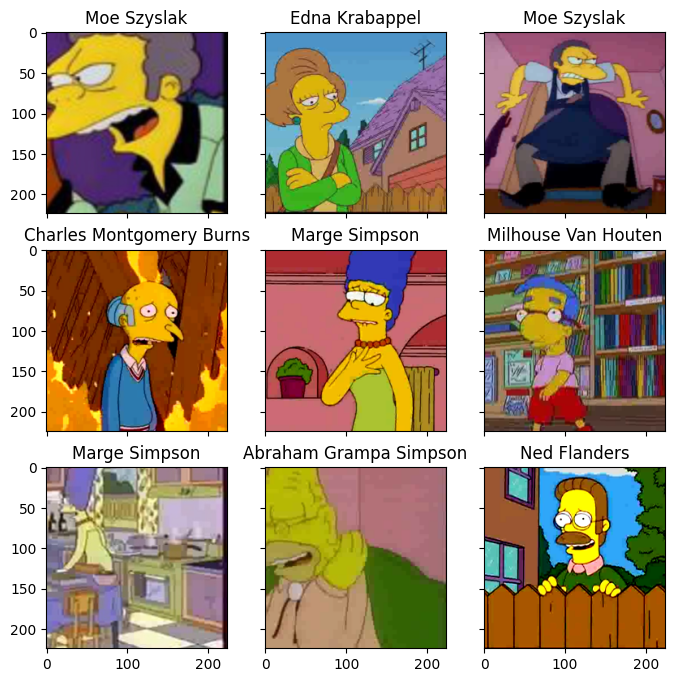

In [18]:
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(8, 8), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0, 4500))
    im_val, label = image_datasets['train'][random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                image_datasets['val'].label_encoder.inverse_transform([label])[0].split('_')))
    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)

In [19]:
def visualization(train, val, is_loss = True):

  if is_loss:
    plt.figure(figsize=(17,10))
    plt.plot(train, label = 'Training loss')
    plt.plot(val, label = 'Val loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

  else:
    plt.figure(figsize=(17,10))
    plt.plot(train, label = 'Training acc')
    plt.plot(val, label = 'Val acc')
    plt.title('Training and validation acc')
    plt.xlabel('Epochs')
    plt.ylabel('Acc')
    plt.legend()
    plt.show()

In [20]:
params_to_update = model_ft.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name, param in model_ft.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            pass
            print("\t",name)

Params to learn:
	 conv1.weight
	 bn1.weight
	 bn1.bias
	 layer1.0.conv1.weight
	 layer1.0.bn1.weight
	 layer1.0.bn1.bias
	 layer1.0.conv2.weight
	 layer1.0.bn2.weight
	 layer1.0.bn2.bias
	 layer1.1.conv1.weight
	 layer1.1.bn1.weight
	 layer1.1.bn1.bias
	 layer1.1.conv2.weight
	 layer1.1.bn2.weight
	 layer1.1.bn2.bias
	 layer2.0.conv1.weight
	 layer2.0.bn1.weight
	 layer2.0.bn1.bias
	 layer2.0.conv2.weight
	 layer2.0.bn2.weight
	 layer2.0.bn2.bias
	 layer2.0.downsample.0.weight
	 layer2.0.downsample.1.weight
	 layer2.0.downsample.1.bias
	 layer2.1.conv1.weight
	 layer2.1.bn1.weight
	 layer2.1.bn1.bias
	 layer2.1.conv2.weight
	 layer2.1.bn2.weight
	 layer2.1.bn2.bias
	 layer3.0.conv1.weight
	 layer3.0.bn1.weight
	 layer3.0.bn1.bias
	 layer3.0.conv2.weight
	 layer3.0.bn2.weight
	 layer3.0.bn2.bias
	 layer3.0.downsample.0.weight
	 layer3.0.downsample.1.weight
	 layer3.0.downsample.1.bias
	 layer3.1.conv1.weight
	 layer3.1.bn1.weight
	 layer3.1.bn1.bias
	 layer3.1.conv2.weight
	 layer3.1.b

In [21]:
model_ft, input_size = initialize_model(cfg.model.name, num_classes, feature_extract=cfg.model.feature_extract, use_pretrained=cfg.model.pretrained)
model_ft = model_ft.to(device)

In [22]:
params_to_update = model_ft.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name, param in model_ft.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            pass
            print("\t",name)

Params to learn:
	 conv1.weight
	 bn1.weight
	 bn1.bias
	 layer1.0.conv1.weight
	 layer1.0.bn1.weight
	 layer1.0.bn1.bias
	 layer1.0.conv2.weight
	 layer1.0.bn2.weight
	 layer1.0.bn2.bias
	 layer1.1.conv1.weight
	 layer1.1.bn1.weight
	 layer1.1.bn1.bias
	 layer1.1.conv2.weight
	 layer1.1.bn2.weight
	 layer1.1.bn2.bias
	 layer2.0.conv1.weight
	 layer2.0.bn1.weight
	 layer2.0.bn1.bias
	 layer2.0.conv2.weight
	 layer2.0.bn2.weight
	 layer2.0.bn2.bias
	 layer2.0.downsample.0.weight
	 layer2.0.downsample.1.weight
	 layer2.0.downsample.1.bias
	 layer2.1.conv1.weight
	 layer2.1.bn1.weight
	 layer2.1.bn1.bias
	 layer2.1.conv2.weight
	 layer2.1.bn2.weight
	 layer2.1.bn2.bias
	 layer3.0.conv1.weight
	 layer3.0.bn1.weight
	 layer3.0.bn1.bias
	 layer3.0.conv2.weight
	 layer3.0.bn2.weight
	 layer3.0.bn2.bias
	 layer3.0.downsample.0.weight
	 layer3.0.downsample.1.weight
	 layer3.0.downsample.1.bias
	 layer3.1.conv1.weight
	 layer3.1.bn1.weight
	 layer3.1.bn1.bias
	 layer3.1.conv2.weight
	 layer3.1.b

In [23]:
criterion = nn.CrossEntropyLoss()

optimizer_ft = optim.SGD(params_to_update, lr=cfg.training.lr, momentum=cfg.training.momentum, nesterov = True)

In [24]:
val_loss = []
val_acc = []
train_loss = []
train_acc = []
best_acc = .0

In [27]:
#모델 훈련

total_epochs = cfg.training.epochs

model_ft, hist_val, hist_train, time_elapsed, best_acc = train_model(
    model_ft,
    dataloaders_dict,
    criterion,
    optimizer_ft,
    save_best_weights_path,
    save_last_weights_path,
    best_acc=0.0,
    num_epochs=total_epochs,
    is_inception=(cfg.model.name == "inception")
)

Epoch 0/1
----------


  0%|          | 0/916 [00:00<?, ?it/s]

train Loss: 0.1240 Acc: 0.9761


  0%|          | 0/393 [00:00<?, ?it/s]

val Loss: 0.0941 Acc: 0.9812

Epoch 1/1
----------


  0%|          | 0/916 [00:00<?, ?it/s]

train Loss: 0.0759 Acc: 0.9860


  0%|          | 0/393 [00:00<?, ?it/s]

val Loss: 0.0687 Acc: 0.9850

Training complete in 7m 21s
Best val Acc: 0.984952


In [28]:
val_loss = hist_val['loss']
val_acc = hist_val['acc']
train_loss = hist_train['loss']
train_acc = hist_train['acc']

In [30]:
train_acc_d = []
for i in range(len(train_acc)):
    train_acc_d.append(train_acc[i].cpu().data)

val_acc_d = []
for i in range(len(val_acc)):
    val_acc_d.append(val_acc[i].cpu().data)

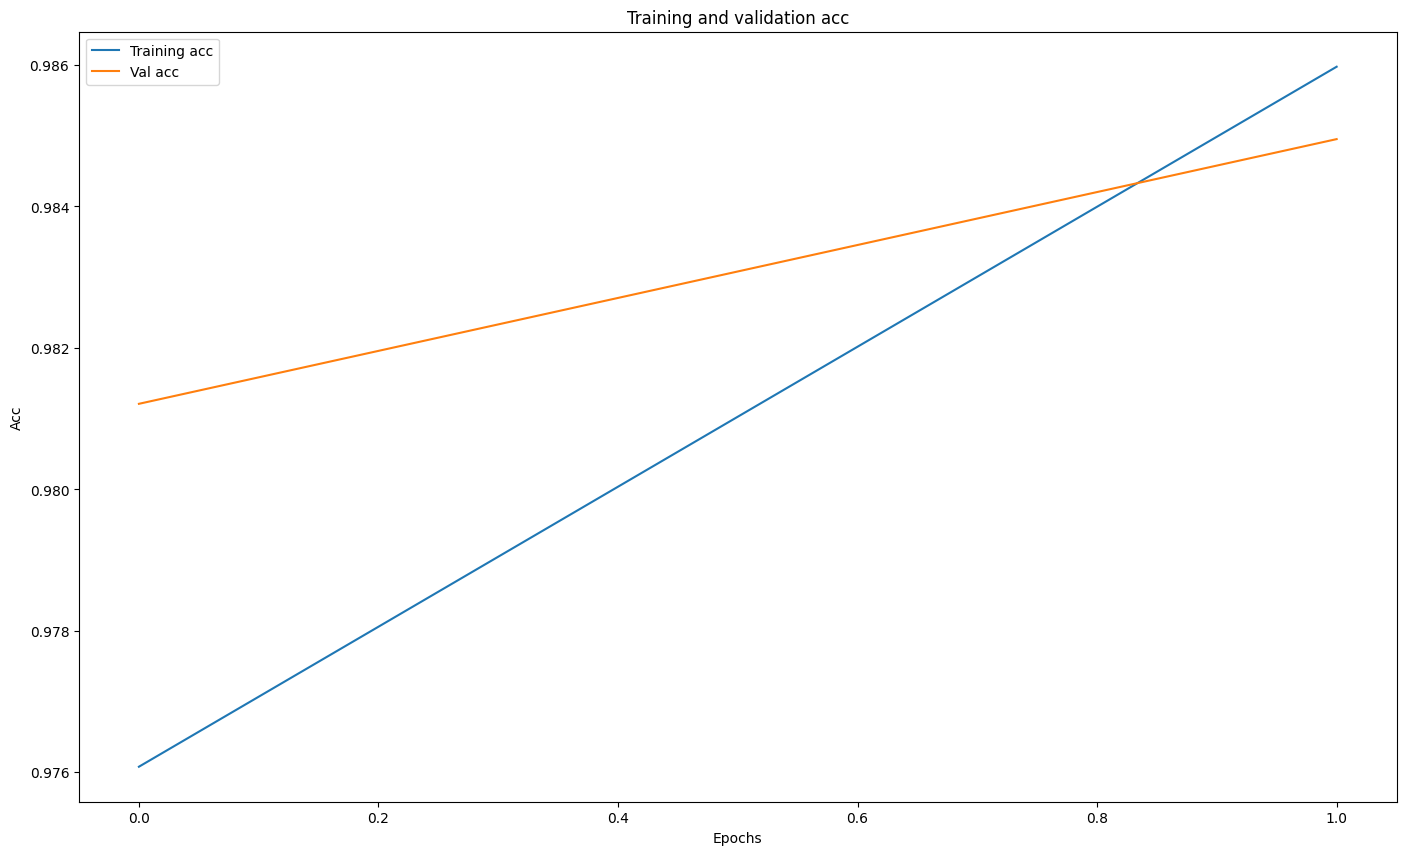

In [31]:
visualization(train_acc_d, val_acc_d, is_loss = False)

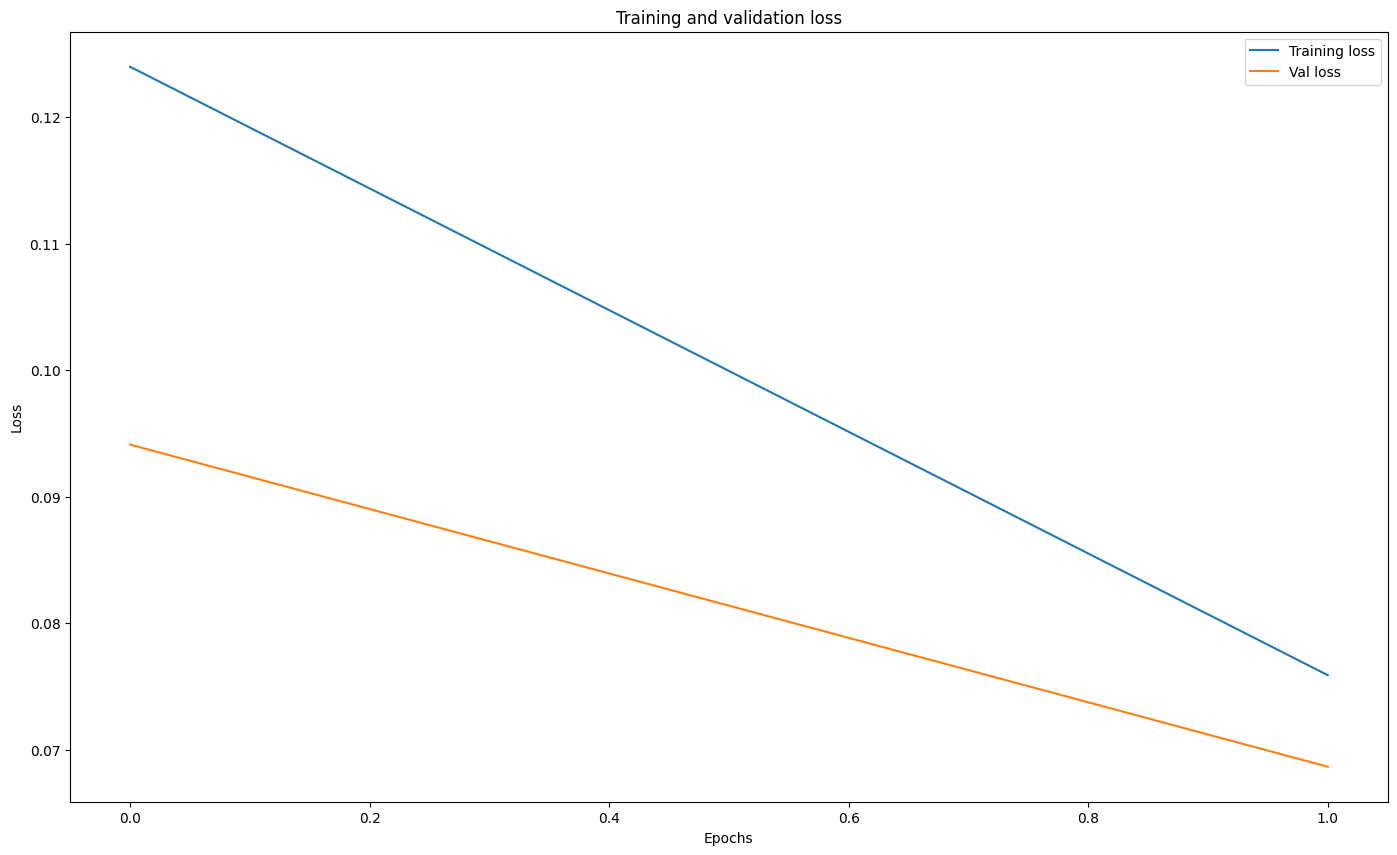

In [32]:
visualization(train_loss, val_loss, is_loss = True)

In [33]:
def predict(model, test_loader):
    with torch.no_grad():
        logits = []

        for inputs in test_loader:
            inputs = inputs.to(device)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)

    probs = nn.functional.softmax(torch.cat(logits), dim=1).numpy()
    return probs

In [34]:
def predict_one_sample(model, img_tensor, device=device):
    with torch.no_grad():
        img_tensor = img_tensor.to(device)
        model.eval()
        y_hat = model(img_tensor).cpu()
        y_pred = torch.nn.functional.softmax(y_hat, dim=1).numpy()
    return y_pred

In [35]:
def confusion_matrix():
    # 실제 label 추출
    actual = [image_datasets['val'][i][1] for i in range( len(image_datasets['val']) ) ]

    # 이미지 추출
    image = [image_datasets['val'][i][0] for i in range( len(image_datasets['val']) ) ]

    img_conf_dataloader = torch.utils.data.DataLoader(image, batch_size=cfg.data.batch_size, shuffle=True, num_workers=cfg.data.num_workers)

    probs = predict(model_ft, img_conf_dataloader)
    preds = np.argmax(probs, axis=1)

    # 테이블 생성
    df = pd.DataFrame({'actual': actual, 'preds': preds})

    confusion_matrix = pd.crosstab(df['actual'], df['preds'], rownames=['Actual'], colnames=['Predicted'], margins = False)

    # 인코더 다운로드
    label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

    # 클래스 목록 가져오기기
    yticklabels = label_encoder.classes_

    plt.subplots(figsize=(20,20))

    sn.heatmap(confusion_matrix, annot=True, fmt="d", linewidths=0.5, cmap="YlGnBu", cbar=False, vmax = 30, yticklabels = yticklabels, xticklabels = yticklabels);

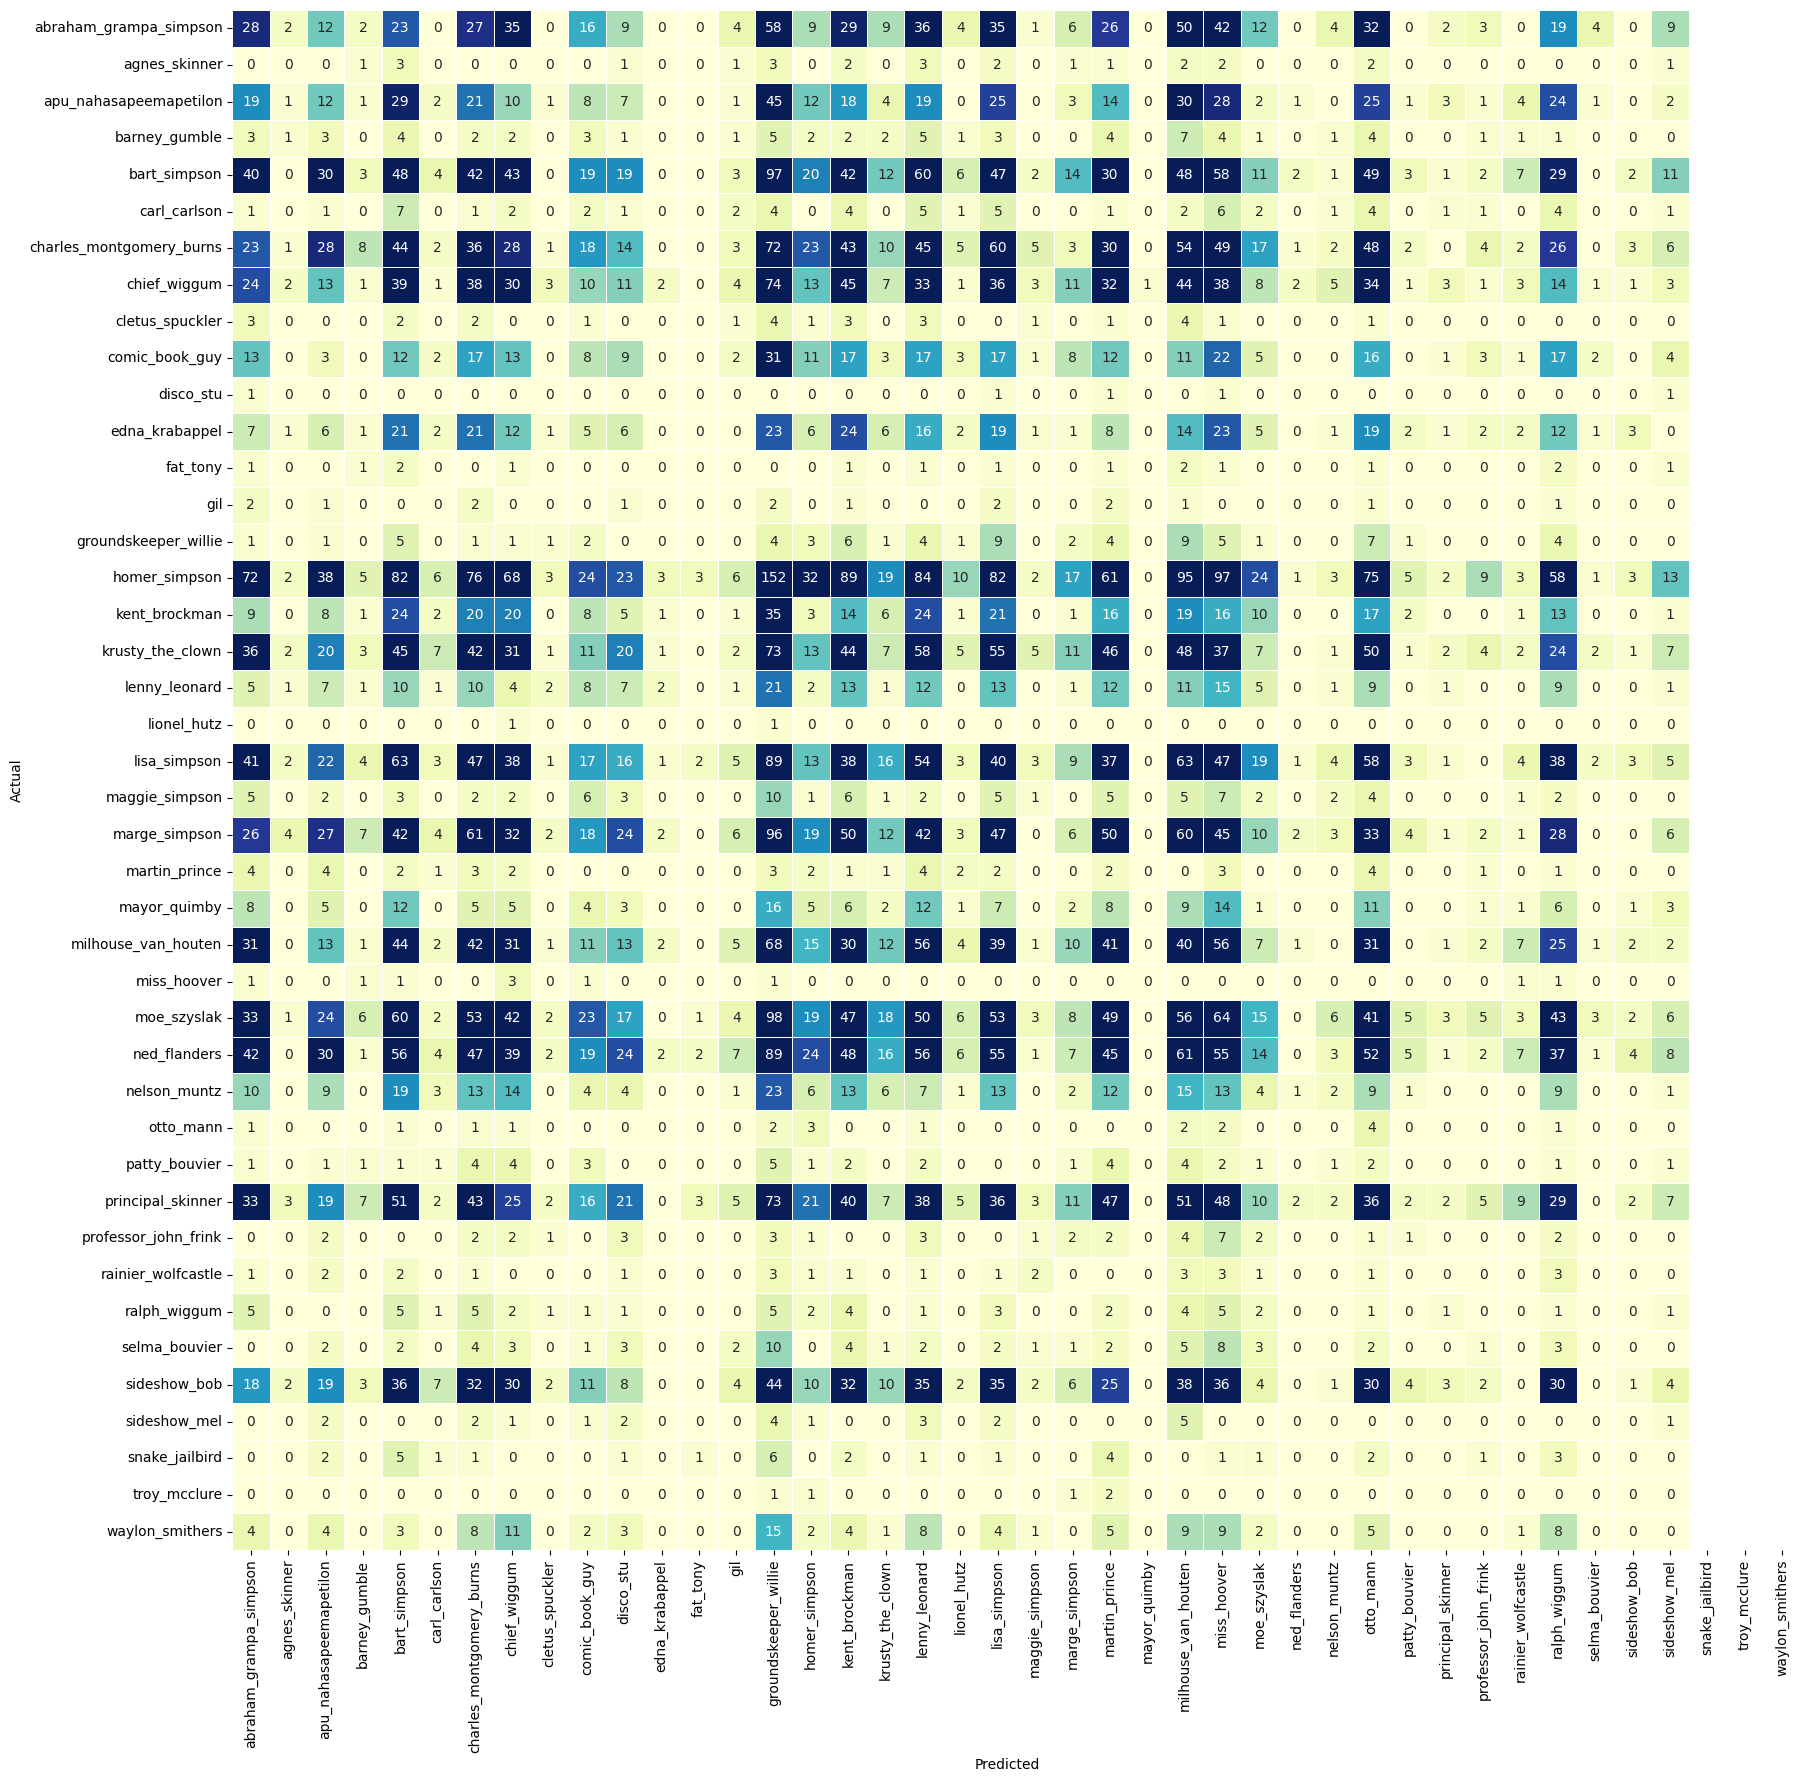

In [36]:
confusion_matrix()

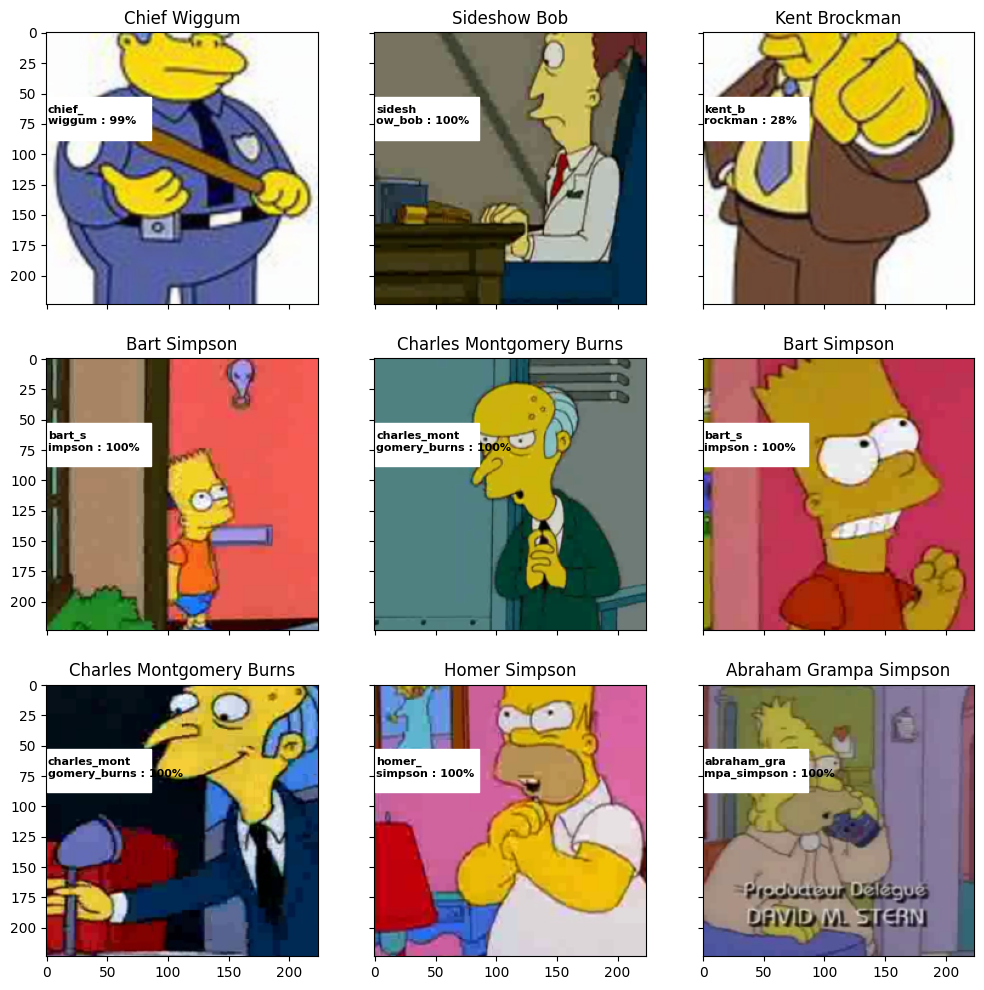

In [37]:
import matplotlib.patches as patches
from matplotlib.font_manager import FontProperties

fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(12, 12), \
                        sharey=True, sharex=True)

label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0, 1000))
    im_val, label = image_datasets['val'][random_characters]
    # inverse_transform은 LabelEncoder() 메서드로, 숫자에서 inverse_transform을 사용하여 클래스 이름을 반환
    # 캐릭터 이름을 가져옴
    img_label = " ".join(map(lambda x: x.capitalize(),\
                image_datasets['val'].label_encoder.inverse_transform([label])[0].split('_')))

    imshow(im_val.data.cpu(), \
          title=img_label, plt_ax=fig_x)

    actual_text = "Actual : {}".format(img_label)

    # 확률 출력할 영역 추가
    fig_x.add_patch(patches.Rectangle((0, 53), 86, 35, color='white'))
    font0 = FontProperties()
    font = font0.copy()
    font.set_family("fantasy")
    prob_pred = predict_one_sample(model_ft, im_val.unsqueeze(0))
    # 확률 가져오기
    predicted_proba = np.max(prob_pred)*100
    y_pred = np.argmax(prob_pred)

    predicted_label = label_encoder.classes_[y_pred]
    predicted_label = predicted_label[:len(predicted_label)//2] + '\n' + predicted_label[len(predicted_label)//2:]
    predicted_text = "{} : {:.0f}%".format(predicted_label,predicted_proba)

    fig_x.text(1, 59, predicted_text , horizontalalignment='left', fontproperties=font,
                    verticalalignment='top',fontsize=8, color='black',fontweight='bold')